### Установка зависимостей

In [77]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

from torchvision import transforms, models
from torchvision.utils import make_grid

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [78]:
import PIL
print(PIL.__version__)

9.4.0


In [79]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [80]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [81]:
!kaggle competitions download -c journey-springfield

journey-springfield.zip: Skipping, found more recently modified local copy (use --force to force download)


In [82]:
!unzip -q journey-springfield.zip

replace characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [83]:
!ls train

simpsons_dataset


In [101]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Nov 14 07:10:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |   1449MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [102]:
import os
import copy
import pickle
import random
import numpy as np
from datetime import datetime
from collections import OrderedDict
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [103]:
SEED = 2023
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
LEARNING_RATE = 0.001
NUM_EPOCHS = 15
BATCH_SIZE = 128
CHECKPOINTS_DIR = '/content/gdrive/MyDrive/journey_springfield_models/'

if not os.path.exists(CHECKPOINTS_DIR):
    os.makedirs(CHECKPOINTS_DIR)

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)
torch.cuda.empty_cache()

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


In [104]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [105]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [106]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [107]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [108]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [109]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [110]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

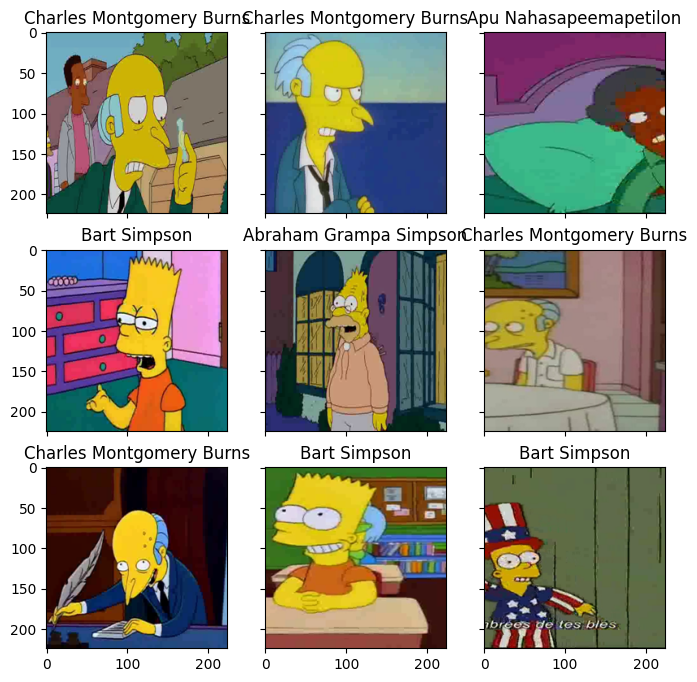

In [111]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

In [112]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [113]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [114]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [115]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()

        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = np.Inf
        date = datetime.now().__str__()
        date = date[:16].replace(':', '-').replace(' ', '-')

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

            if val_loss < best_loss:
                best_loss = val_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                print("Saving model for best loss")

                checkpoint = {
                'state_dict': best_model_wts
                }

                model_file_name = f'experiment0_model_{date}.pth.tar'

                model_filepath = os.path.join(CHECKPOINTS_DIR, model_file_name)

                torch.save(checkpoint, model_filepath)

            print('Best_loss: {:.4f}'.format(best_loss))

    return history

In [116]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [118]:
n_classes = len(np.unique(train_val_labels))

# simple_cnn = SimpleCnn(n_classes).to(DEVICE)
# print("we will classify :{}".format(n_classes))
# print(simple_cnn)

model = models.resnet50(weights="IMAGENET1K_V2")

# for param in model.parameters():
#     param.requires_grad = False

model.fc = nn.Linear(2048, n_classes)

# model.fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1024)),
#                                       ('relu', nn.ReLU()),
#                                       ('dropout',nn.Dropout(0.3)),
#                                       ('fc2', nn.Linear(1024, 512)),
#                                       ('relu', nn.ReLU()),
#                                       ('drop', nn.Dropout(0.3)),
#                                       ('fc3', nn.Linear(512, n_classes))
#                                       ]))

model = model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 73.2MB/s]


Запустим обучение сети.

In [119]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [120]:
history = train(train_dataset, val_dataset, model=model, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 0.6014681343641529


epoch:   7%|▋         | 1/15 [04:53<1:08:29, 293.53s/it]


Epoch 001 train_loss: 0.6015     val_loss 0.3734 train_acc 0.8560 val_acc 0.8984
Saving model for best loss
Best_loss: 0.3734
loss 3.1592928236537285


epoch:  13%|█▎        | 2/15 [09:35<1:02:07, 286.73s/it]


Epoch 002 train_loss: 3.1593     val_loss 3.1203 train_acc 0.1114 val_acc 0.1074
Best_loss: 0.3734
loss 3.1156867466061593


epoch:  20%|██        | 3/15 [14:12<56:27, 282.32s/it]


Epoch 003 train_loss: 3.1157     val_loss 3.1158 train_acc 0.1071 val_acc 0.1095
Best_loss: 0.3734
loss 3.1043846057443774


epoch:  27%|██▋       | 4/15 [18:53<51:37, 281.60s/it]


Epoch 004 train_loss: 3.1044     val_loss 3.0680 train_acc 0.1054 val_acc 0.1204
Best_loss: 0.3734
loss 2.946020579549171


epoch:  33%|███▎      | 5/15 [23:31<46:45, 280.59s/it]


Epoch 005 train_loss: 2.9460     val_loss 2.7084 train_acc 0.1522 val_acc 0.2134
Best_loss: 0.3734
loss 2.287242222541502


epoch:  40%|████      | 6/15 [28:12<42:04, 280.45s/it]


Epoch 006 train_loss: 2.2872     val_loss 1.9638 train_acc 0.3567 val_acc 0.4431
Best_loss: 0.3734
loss 1.5923766621404927


epoch:  47%|████▋     | 7/15 [32:51<37:20, 280.10s/it]


Epoch 007 train_loss: 1.5924     val_loss 1.4441 train_acc 0.5507 val_acc 0.6093
Best_loss: 0.3734
loss 1.167141726642849


epoch:  53%|█████▎    | 8/15 [37:33<32:44, 280.62s/it]


Epoch 008 train_loss: 1.1671     val_loss 1.1092 train_acc 0.6706 val_acc 0.6987
Best_loss: 0.3734
loss 0.8667903811174241


epoch:  60%|██████    | 9/15 [42:12<28:02, 280.37s/it]


Epoch 009 train_loss: 0.8668     val_loss 0.8684 train_acc 0.7550 val_acc 0.7637
Best_loss: 0.3734
loss 0.6497249451364876


epoch:  67%|██████▋   | 10/15 [46:53<23:22, 280.45s/it]


Epoch 010 train_loss: 0.6497     val_loss 0.7763 train_acc 0.8152 val_acc 0.7965
Best_loss: 0.3734
loss 0.520247478945725


epoch:  73%|███████▎  | 11/15 [51:33<18:40, 280.22s/it]


Epoch 011 train_loss: 0.5202     val_loss 0.7259 train_acc 0.8488 val_acc 0.8107
Best_loss: 0.3734
loss 0.41249081914429


epoch:  80%|████████  | 12/15 [56:11<13:59, 279.68s/it]


Epoch 012 train_loss: 0.4125     val_loss 0.6677 train_acc 0.8789 val_acc 0.8326
Best_loss: 0.3734
loss 0.29728199660121213


epoch:  87%|████████▋ | 13/15 [1:00:50<09:18, 279.32s/it]


Epoch 013 train_loss: 0.2973     val_loss 0.6258 train_acc 0.9127 val_acc 0.8431
Best_loss: 0.3734
loss 0.21761360062490687


epoch:  93%|█████████▎| 14/15 [1:05:28<04:38, 278.96s/it]


Epoch 014 train_loss: 0.2176     val_loss 0.6165 train_acc 0.9360 val_acc 0.8540
Best_loss: 0.3734
loss 0.19448189941878014


epoch: 100%|██████████| 15/15 [1:10:03<00:00, 280.24s/it]


Epoch 015 train_loss: 0.1945     val_loss 0.6102 train_acc 0.9384 val_acc 0.8506
Best_loss: 0.3734


Построим кривые обучения

In [121]:
loss, acc, val_loss, val_acc = zip(*history)

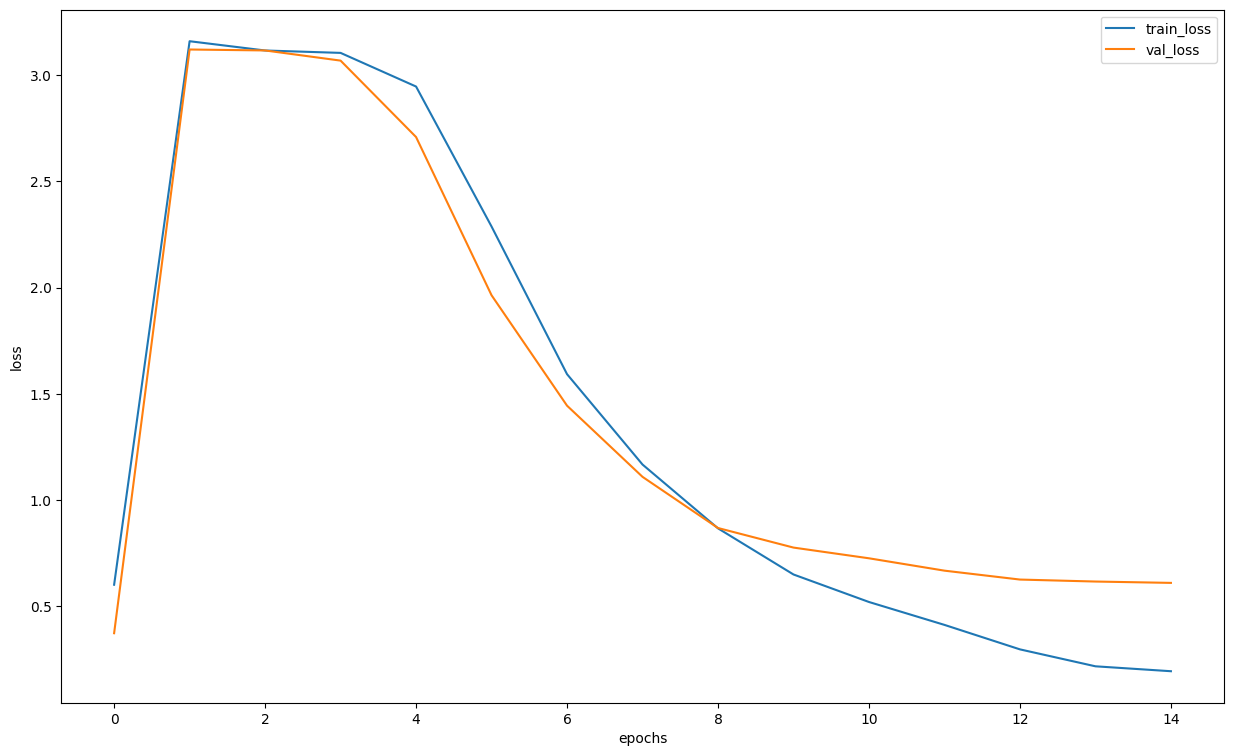

In [122]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

In [123]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [124]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [125]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [126]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [127]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [128]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.75


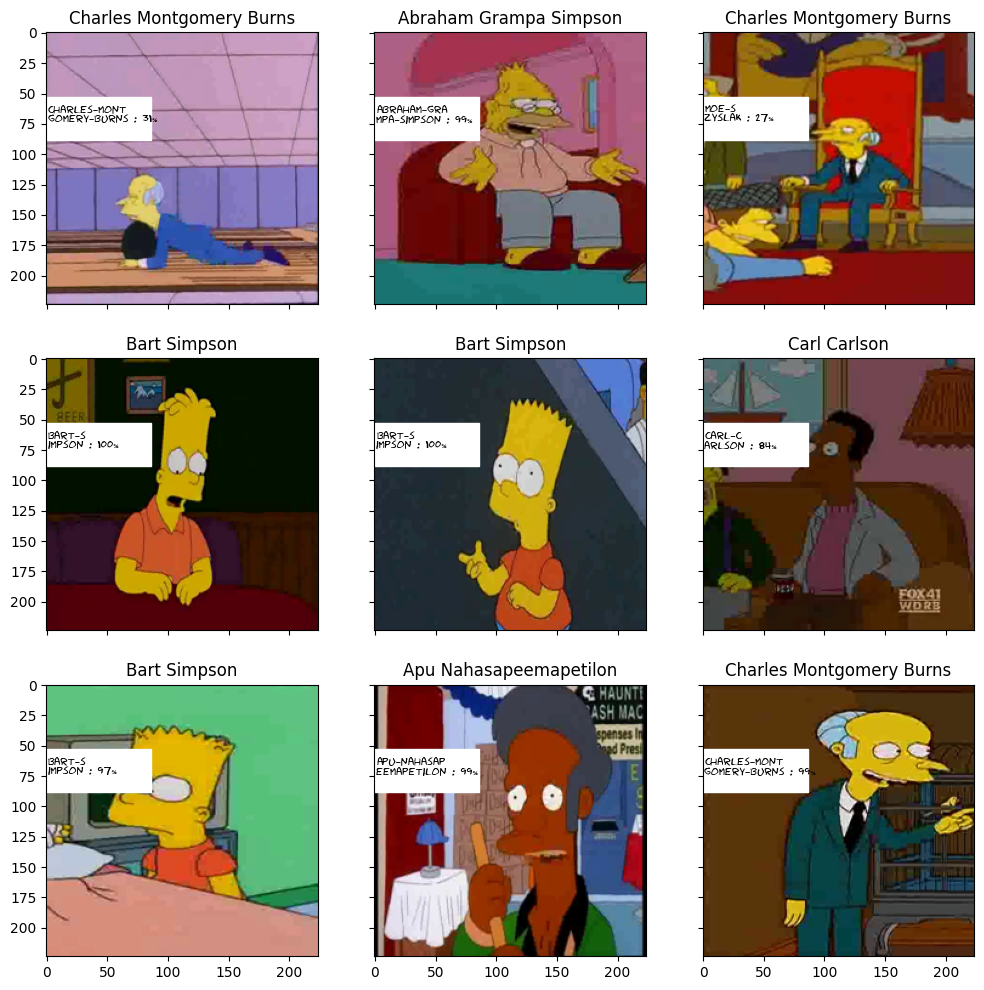

In [129]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

In [130]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [131]:
! ls

characters_illustration.png  label_encoder.pkl	       sample_submission.csv
gdrive			     resnet_50_submission.csv  testset
journey-springfield.zip      sample_data	       train


In [132]:
import pandas as pd
# my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [133]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [134]:
submission_filepath = os.path.join(CHECKPOINTS_DIR, 'resnet_50_augmentations.csv')
my_submit.to_csv(submission_filepath, index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
